# Data structures

Author(s): Jukka Aho (<jukka.aho@kapsi.fi>)

####Abstract
A proposal how to work with element, nodal etc. data. Main point is that we have one simple principle: *everything is field*. That is, variables are recorded to nodes, element nodes, element gauss points dynamically and there's nothing "fixed". This allows us to write very elegant "microsolvers" and very easy model structure. Concept will be very easy to unit test. Moreover, when we keep structures as simple as possible, the concept is easy to understand.

First we talk about this "model". It could be something very easy, like struct of dicts. We don't care *what* we are recording to field or *how many* fields exists for single node/element/model, but we are caring about *where* (in topological sense) we need to save values. For example:

### Model fields
Global variables like 
- mesh file name
- results file name
- time

### Nodal fields
- primal variable after solution

### Element fields
- body id
- connected nodes
- shape function family
- dimension
- everything else we don't have to interpolate

### Element node fields
Defined in element local nodes
- density
- young's modulus
- thickness
- boundary load
- if shape functions are defined, we can interpolate these inside element

### Element gauss fields
Defined in element gauss points
- stress tensor
- pretty much everything we need during the solution
- these can be extrapolated to element local nodes

So, what this means in practice?

In [1]:
type Model
    mo  # For global variables
    no  # For nodes
    el  # For elements
    elno  # For element nodes
    elga  # For element gauss points
end

In [2]:
function new_model()
    """Initialize empty model.
    """
    return Model(Dict(), Dict(), Dict(), Dict(), Dict())
end

new_model (generic function with 1 method)

In [3]:
function new_field(field_type, field_name)
    d = Dict()
    setindex!(field_type, d, field_name)
    return d
end

new_field (generic function with 1 method)

And that's it. We can do a lot of things using that simple construction when we are dealing with dynamic languages. 

Structure is following:

    model.mo[parameter] = value
    model.no[field][node_id] = value
    model.el[field][element_id] = value
    model.elno[field][element_id][local_node_id] = value
    model.elga[field][element_id][local_gauss_id] = value

`Value` can be scalar, vector, tensor, composite type or whatever is needed. 

`Field` can also be whatever needed: temperature, displacement, velocity, pressure, density, etc.

Examples:

    model.mo["simulation_time"] = datetime.datetime.now()
    model.no["coords"][node_id] = [1, 2, 3]
    model.el["color"][element_id] = "red"
    model.elno["thickness"][element_id][1] = 5  #  1 here stands for "first local node of element"
    model.elno["thickness"][element_id][2] = 10
    model.elga["stress"][element_id] = [1 2; 3 4]

We apply *solvers* to our model. Solver is generic name for a function that uses model data and updates it.

## Example 1, normal directions in global nodes

Next we can start writing our microsolvers. Our goal is to calculate normal direction in nodal points, averaged from element nodes.

INFO: Loading help data...


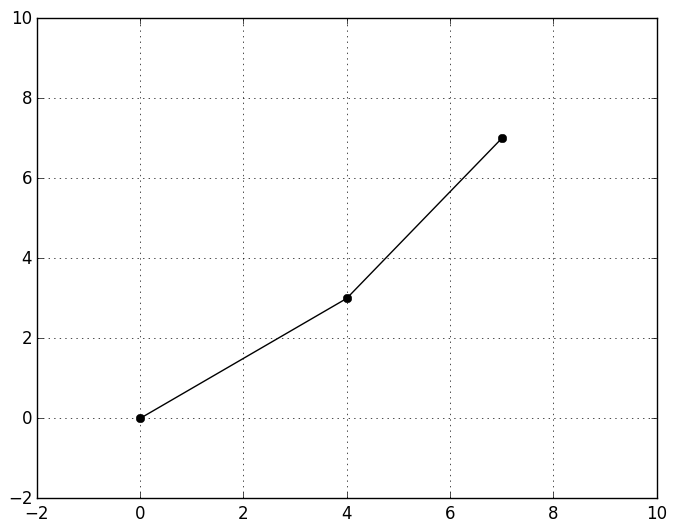

(-2,10)

In [4]:
using PyPlot
plot([0, 4, 7], [0, 3, 7], "-ko")
grid()
xlim(-2, 10)
ylim(-2, 10)

First obvious thing is to generate or read geometry to model.

In [5]:
function dummymeshreader(model)
    """Read mesh to model. Rewrite older mesh. This microsolver is for demonstration purposes."""

    # Create new field for node coordinates. Coordinates is nodal field.
    coords = new_field(model.no, "coords")
    reverse_connectivity = new_field(model.no, "connects_to")

    # Create new field for connectivity and dimension. This is element property.
    connectivity = new_field(model.el, "connectivity")
    dimension = new_field(model.el, "dimension")

    # Do actual reading, call another microsolver which reads geometry e.g. ABAQUS

    # Here we just create three nodes and two linear segments to demonstrate the concept
    coords[1] = [0.0, 0.0]
    coords[2] = [4.0, 3.0]
    coords[3] = [7.0, 7.0]
    connectivity[1] = [1, 2]
    connectivity[2] = [2, 3]
    dimension[1] = 1
    dimension[2] = 1
    reverse_connectivity[1] = [1]
    reverse_connectivity[2] = [1, 2]
    reverse_connectivity[3] = [2]
    return model
end

function test_dummymeshreader()
    m = new_model() # Create new model
    dummymeshreader(m) # Apply microsolver "dummymeshreader" to model m
    println(m)
    @assert m.no["coords"][1] == [0.0, 0.0]
    @assert m.el["connectivity"][1] == [1, 2]
end

test_dummymeshreader()

Model(Dict{Any,Any}(),{"connects_to"=>{2=>[1,2],3=>[2],1=>[1]},"coords"=>{2=>[4.0,3.0],3=>[7.0,7.0],1=>[0.0,0.0]}},{"connectivity"=>{2=>[2,3],1=>[1,2]},"dimension"=>{2=>1,1=>1}},Dict{Any,Any}(),Dict{Any,Any}())


Our next microsolver assigns some function space to elements. We use linear Lagrange polynomials. We test routine with some simple interpolation. We want to find midpoint of first element [0.0, 0.0] -> [4.0, 3.0] but because we can interpolate only from element nodes, we need some utility functions to move field variables from nodes to element nodes. So we need to write another microsolver which makes such transformation.

In [6]:
function no2elno(model, field)
    """Move field from nodes to element nodes."""
    f = new_field(model.elno, field)
    for (elid, node_ids) in model.el["connectivity"]  # loop through element connectivity list
        f[elid] = Dict()
        for (i, c) in enumerate(node_ids)
            f[elid][i] = model.no[field][c]
        end
    end
end

function test_no2elno()
    m = new_model()
    dummymeshreader(m)
    no2elno(m, "coords")
    @assert "coords" in keys(m.elno)  # new element node field
    el = m.elno["coords"][1]  # first element ..
    println(el)
    @assert el[1] == [0.0, 0.0]
    @assert el[2] == [4.0, 3.0]
end

test_no2elno()

{2=>[4.0,3.0],1=>[0.0,0.0]}


In [20]:
function get_shape_functions(family, dim, order)
    if family == "Lagrange"
        if dim == 1
            if order == 1
                return xi -> [0.5*(1-xi) 0.5*(1+xi)]
            end
        end
    end
    throw("Unknown shape function requested.")
end

function interpolate(shape_functions, elnofield, xi)
    result = zeros(size(elnofield[1]))
    sf = shape_functions(xi)
    for i=1:length(sf)
        result += sf[i]*elnofield[i]
    end
    return result
end

function test_shape_functions()
    sf = get_shape_functions("Lagrange", 1, 1)
    println(sf(-1))
    println(sf(1))
    @assert sf(-1) == [1 0]
    @assert sf(1) == [0 1]
end

function test_define_fuction_space()
    m = new_model()
    dummymeshreader(m) # Read mesh
    no2elno(m, "coords") # Move nodal field (coordinates) from nodes to element nodes
    sf = get_shape_functions("Lagrange", 1, 1)
    midpoint = interpolate(sf, m.elno["coords"][1], 0.0)
    println(m.elno["coords"][1])
    println(midpoint)
    @assert midpoint == [2.0, 1.5]
end

test_shape_functions()
test_define_fuction_space()

[1.0 0.0]
[0.0 1.0]
{2=>[4.0,3.0],1=>[0.0,0.0]}
[2.0,1.5]


Our next microsolver introduces new field, namely normal direction in *element nodes*

In [8]:
function get_shape_function_derivatives(family, dim, order)
    if family == "Lagrange"
        if dim == 1
            if order == 1
                return xi -> [-0.5 0.5]
            end
        end
    end
    throw("Unknown shape function requested.")
end

function calculate_element_normals(model)
    """A solver to calculate boundary element normals."""
    normals = new_field(model.elno, "normals")
    coords = model.elno["coords"]
    dsf = get_shape_function_derivatives("Lagrange", 1, 1)
    for (elid, node_ids) in model.el["connectivity"]
        normals[elid] = Dict()

        t = interpolate(dsf, coords[elid], -1)
        n = [t[2], -t[1]]
        n /= norm(n)
        normals[elid][1] = n/norm(n)

        t = interpolate(dsf, coords[elid], 1)
        n = [t[2], -t[1]]
        n /= norm(n)
        normals[elid][2] = n/norm(n)

    end
end

function test_element_normal_field_calculation()
    m = new_model()
    dummymeshreader(m) # Read mesh
    no2elno(m, "coords") # Move nodal field (coordinates) from nodes to element nodes
    calculate_element_normals(m)
    n = [3, -4]
    n /= norm(n)
    println(n)
    element_normals = m.elno["normals"][1] # Normals of first element
    println(element_normals)
    @assert element_normals[1] == n
    @assert element_normals[2] == n
end

test_element_normal_field_calculation()

[0.6,-0.8]
{2=>[0.6,-0.8],1=>[0.6,-0.8]}


Our last solver reads element node values and transforms them back to nodal field values. We now have different values for each element node so we have to somehow combine them. Let's take simple average for now.

In [9]:
function elno2no(model, field)
    """Move field from element nodes to global nodes."""
    f = new_field(model.no, field)
    for (nid, elids) in model.no["connects_to"]  # loop through nodes "reverse" connectivity list
        # find variable dimension from first element first local variable
        vardim = size(model.elno[field][elids[1]][1])
        f[nid] = zeros(vardim)
        for elid in elids
            local_node_id = findfirst(model.el["connectivity"][elid], nid)
            f[nid] += model.elno[field][elid][local_node_id]
        end
        f[nid] /= length(elids)
    end
end

function test_elno2no()
    m = new_model()
    dummymeshreader(m)
    no2elno(m, "coords") # Move nodal field (coordinates) from nodes to element nodes
    calculate_element_normals(m) # Calculate normals in elements
    #println(m.elno["normals"])
    elno2no(m, "normals") # Move element node normals back to global nodes
    n1 = [3, -4]
    n1 /= norm(n1)
    n2 = [4, -3]
    n2 /= norm(n2)
    navg = 0.5*(n1+n2)
    println(navg)
    println(keys(m.no))
    println(m.no["normals"])
    @assert m.no["normals"][1] == n1  # Normal of first node
    @assert m.no["normals"][2] == navg  # Normal of middle node
    @assert m.no["normals"][3] == n2  # Normal of third node
end

test_elno2no()

[0.7,-0.7]
{"connects_to","normals","coords"}
{2=>[0.7,-0.7],3=>[0.8,-0.6],1=>[0.6,-0.8]}


So our final solver combines all above to find correct normal directions in boundary nodes:

In [10]:
function calculate_node_normals(model)
    no2elno(model, "coords") # Move nodal field (coordinates) from nodes to element nodes
    calculate_element_normals(model) # Calculate normals in elements
    elno2no(model, "normals") # Move element node normals back to global nodes
    for (nid, ndir) in model.no["normals"]
        model.no["normals"][nid] /= norm(model.no["normals"][nid])
    end
end

function test_calculate_node_normals()
    m = new_model()
    dummymeshreader(m)
    calculate_node_normals(m)
    n1 = [3, -4]
    n1 /= norm(n1)
    n2 = [4, -3]
    n2 /= norm(n2)
    navg = 0.5*(n1+n2)
    navg /= norm(navg)
    println(m.no["normals"])
    @assert m.no["normals"][1] == n1  # Normal of first node
    @assert m.no["normals"][2] == navg  # Normal of middle node
    @assert m.no["normals"][3] == n2  # Normal of third node
end
    
test_calculate_node_normals()

{2=>[0.7071067811865475,-0.7071067811865475],3=>[0.8,-0.6],1=>[0.6,-0.8]}


### Summary for example 1

2 {2=>[7.0,7.0],1=>[4.0,3.0]}
1 {2=>[4.0,3.0],1=>[0.0,0.0]}
[4.0,3.0]
[0.7071067811865475,-0.7071067811865475]


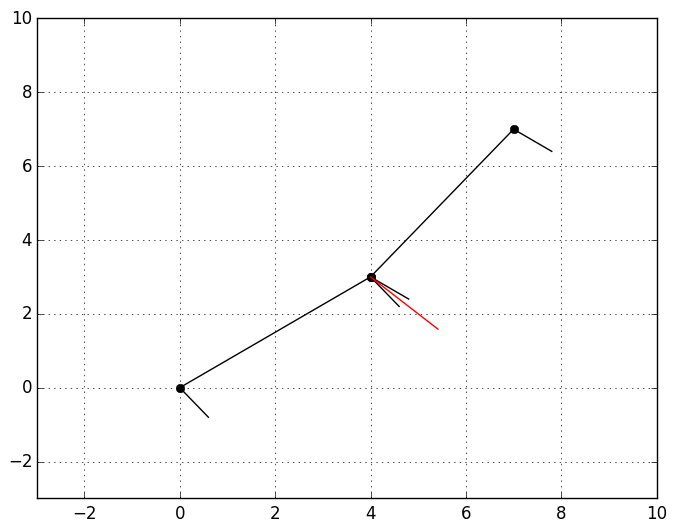

(-3,10)

In [11]:
m = new_model()
dummymeshreader(m)
calculate_node_normals(m)
for i in keys(m.el["connectivity"])
    c = m.elno["coords"][i]
    println(i, " ", c)
    nor1 = m.elno["normals"][i][1]
    nor2 = m.elno["normals"][i][2]
    plot([c[1][1], c[2][1]], [c[1][2], c[2][2]], "-ko")
    plot([c[1][1], c[1][1]+nor1[1]], [c[1][2], c[1][2]+nor1[2]], "-k")
    plot([c[2][1], c[2][1]+nor2[1]], [c[2][2], c[2][2]+nor2[2]], "-k")
end

node2_normal = m.no["normals"][2]
node2_coords = m.no["coords"][2]
println(node2_coords)
println(node2_normal)
plot([node2_coords[1], node2_coords[1]+node2_normal[1]*2],
     [node2_coords[2], node2_coords[2]+node2_normal[2]*2], "-r")

grid()
xlim(-3, 10)
ylim(-3, 10)

Here small black lines are element *local* normal directions. Red line is *global* normal direction, defined in node point. Element local directions are in field `model.elno["normals"][elid][id]` while global direction defined in nodes are in `model.no["normals"][node_id]`.

## Example 2, poisson equation in 1d

Next we solve PDE $ku'' = 1$ in domain $I=[0, 1]$ with boundary conditions $u(0)=0$, $u'(1)=1$. For this we need to define field variable for $k$, let's call it to stiffness and it must be defined in element nodes because we have to integrate over it. $k$ not necessarily have to be constant that way. After standard FE assembly and solution discrete $u$ values are in nodal field, let's call it to displacement. 

Accurate solution is $u=\frac{1}{2}x^2$ for $k=1$.

First we must again write some solver to generate geometry. In 1d this is easy enough (even for me ;)).

In [12]:
function generate_1d_mesh(model, N, I)
    """Generate 1D mesh with N nodes for interval I."""
    coords = new_field(model.no, "coords")
    connectivity = new_field(model.el, "connectivity")
    X = linspace(I[1], I[2], N)
    for (i, x) in enumerate(X)
        model.no["coords"][i] = [x]
    end
    for i=1:N-1
        model.el["connectivity"][i] = [i, i+1]
    end
end

generate_1d_mesh (generic function with 1 method)

In [13]:
N = 5  # Number of nodes in model
mo = new_model()
generate_1d_mesh(mo, N, [0, 1])
no2elno(mo, "coords") # again move global coords to node local coords
for i=1:N
    println("node ", i, " x = ", mo.no["coords"][i])
end
for i=1:N-1
    println("element ", i, " connects to nodes ", mo.el["connectivity"][i])
end

node 1 x = [0.0]
node 2 x = [0.25]
node 3 x = [0.5]
node 4 x = [0.75]
node 5 x = [1.0]
element 1 connects to nodes [1,2]
element 2 connects to nodes [2,3]
element 3 connects to nodes [3,4]
element 4 connects to nodes [4,5]


Our elements need stiffness and force. Let's define new field for them. Note that both are defined on *element nodes* (we must interpolate them in assembly).

In [14]:
new_field(mo.elno, "stiffness")
new_field(mo.elno, "force")
for i=1:N-1
    mo.elno["stiffness"][i] = Dict()
    mo.elno["stiffness"][i][1] = [1.0]
    mo.elno["stiffness"][i][2] = [1.0]
    mo.elno["force"][i] = Dict()
    mo.elno["force"][i][1] = [1.0]
    mo.elno["force"][i][2] = [1.0]
end
mo.elno["stiffness"]

Dict{Any,Any} with 4 entries:
  4 => {2=>[1.0],1=>[1.0]}
  2 => {2=>[1.0],1=>[1.0]}
  3 => {2=>[1.0],1=>[1.0]}
  1 => {2=>[1.0],1=>[1.0]}

Next the solver. For simplicity boundary conditions are handled "silly". We also skip defining function spaces for now.

In [15]:
function poissonsolver1d(model)
    # Note that we could save all intermediate variables like jacobian, stiffness etc. to
    # model gauss points. TODO.
    ipoints = [-sqrt(1/3) sqrt(1/3)]
    iweights = [1 1]
    K = zeros(N, N)
    F = zeros(N)
    basis = get_shape_functions("Lagrange", 1, 1)
    #println(basis(-1), " ", basis(1))
    dbasis = get_shape_function_derivatives("Lagrange", 1, 1)
    for i=1:N-1  # Loop through elements

        # create local stiffness matrix and force vector
        k = zeros(2, 2)
        f = zeros(2)
        for j=1:length(iweights)
            wi = iweights[j]
            ip = ipoints[j]
            N = basis(ip)
            dNdxi = dbasis(ip)
            J = norm(interpolate(dbasis, model.elno["coords"][i], ip))
            dNdx = dNdxi*J^-1

            # stiffness and force in integration point, interpolated from element nodes
            # (not have to be constant then necessary)
            stiff = interpolate(basis, model.elno["stiffness"][i], ip)[1]
            force = interpolate(basis, model.elno["force"][i], ip)[1]
            k += wi * stiff * dNdx'*dNdx * J
            # FIXME: There's a mistake somewhere ...
            f -= wi * force * N' * J
            #println(N')
        end
        
        # assemble to global matrices
        gdofs = model.el["connectivity"][i]
        K[gdofs, gdofs] += k
        F[gdofs] += f
    end
    # add neumann boundary condition to RHS and solve
    F[end] += 1.0
    u = zeros(N)
    free_dofs = 2:N
    u[free_dofs] = K[free_dofs, free_dofs] \ F[free_dofs]
    #println(K[free_dofs, free_dofs])
    #println(F[free_dofs])
    #println(u)
    # create new field and save results to nodes
    new_field(model.no, "displacement")
    for i=1:N
        model.no["displacement"][i] = u[i]
    end
end

poissonsolver1d (generic function with 1 method)

In [16]:
poissonsolver1d(mo)

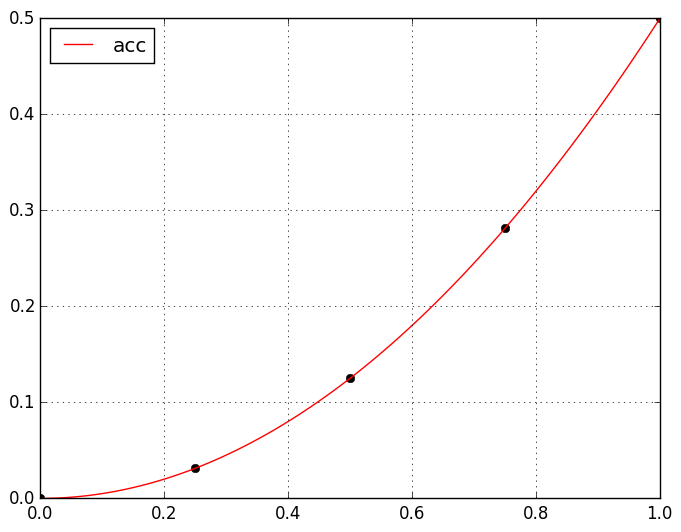

In [17]:
for i=1:N
    plot(mo.no["coords"][i][1], mo.no["displacement"][i], "ko")
end
x = linspace(0, 1)
plot(x, 1/2*x.^2, "-r", label="acc")
legend(loc="best")
grid()
